# Node properties
## Introduction
In this tutorial we will cover inspection of node (that is, cell) properties.

## Preamble
The code in this section is identical to the code in the sections from "Preamble" to "Properties and methods" from the previous tutorial. It assumumes that you have already downloaded the circuit. If not, take a look to the notebook **01_circuits** (Downloading a circuit).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import bluepysnap

# load the circuit and store the node population
circuit_path = "sonata/circuit_sonata.json"
circuit = bluepysnap.Circuit(circuit_path)
node_population = circuit.nodes["thalamus_neurons"]
node_population.property_names

{'@dynamics:holding_current',
 '@dynamics:threshold_current',
 'etype',
 'layer',
 'model_template',
 'model_type',
 'morph_class',
 'morphology',
 'mtype',
 'orientation_w',
 'orientation_x',
 'orientation_y',
 'orientation_z',
 'region',
 'rotation_angle_xaxis',
 'rotation_angle_yaxis',
 'rotation_angle_zaxis',
 'synapse_class',
 'x',
 'y',
 'z'}

## Node properties and methods
Node populations provide information about the collection of nodes, and what information is available for each of the nodes themselves.

Let's begin by retrieving all nodes with their associated layer, synapse type, and position in 3D space. We can then use this to understand how the synapse types are distributed between layers.

In [2]:
df_all = node_population.get(properties=['layer', 'synapse_class', 'x', 'y', 'z'])
df_all.groupby(['synapse_class', 'layer']).count()

x      y      z
synapse_class layer                     
EXC           Rt         0      0      0
              VPL    64856  64856  64856
INH           Rt     35567  35567  35567
              VPL      342    342    342

We can also easily visualize, for example, the distribution of nodes in layers

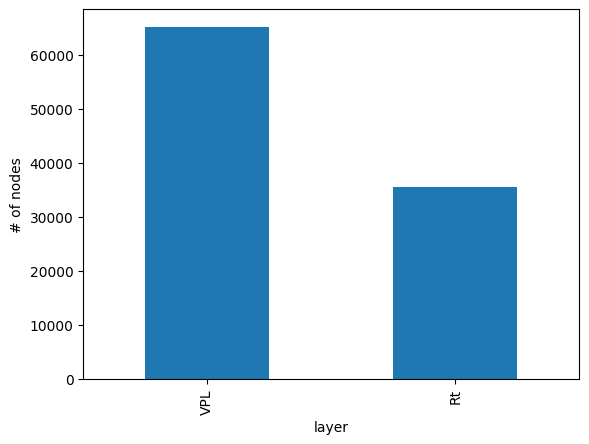

In [3]:
df = node_population.get(properties=['layer']).value_counts().reset_index()
df.plot.bar(x='layer', ylabel='# of nodes', legend=False);

Let's now plot the positions of the synapses by type in the x-z plane.

In [4]:
df_all.head()

,layer,synapse_class,x,y,z
node_ids,,,,,
0,Rt,INH,175.000000,575.000000,225.000000
1,Rt,INH,179.044281,593.194763,200.260788
2,Rt,INH,196.751480,563.684509,206.200989
3,Rt,INH,169.940216,579.091736,253.004227
4,Rt,INH,156.274872,572.608337,235.786240


/gpfs/bbp.cscs.ch/data/scratch/proj30/home/herttuai/NSETM_2185/venv/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1256: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


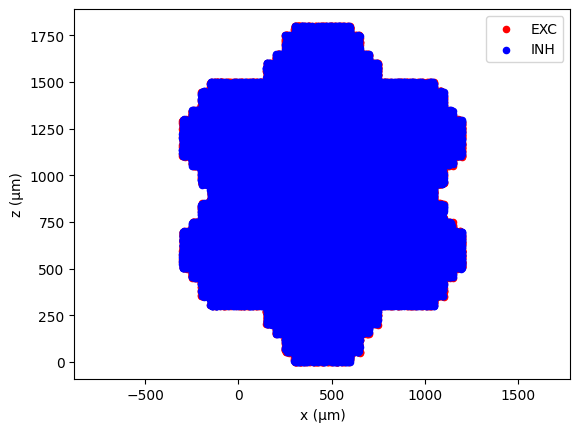

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1)

df_grouped = df_all.groupby('synapse_class')

for color, (name, group) in zip(('r', 'b'), df_grouped):
    group.plot(x='x', y='z', c=color, kind='scatter', ax=ax, label=name)

ax.axis('equal')
ax.set_xlabel(u'x (μm)')
ax.set_ylabel(u'z (μm)');

Now we will visualize the positions of nodes in each layer

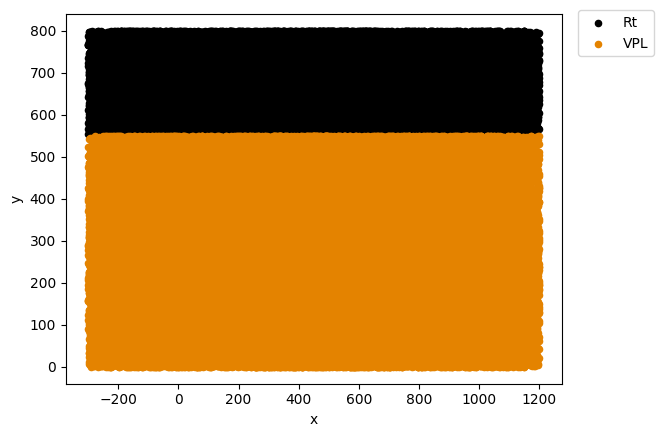

In [6]:
# get all cell positions and group by layer
df_all = node_population.get(properties=['x', 'y', 'z', 'layer'])
df_grouped = df_all.groupby('layer')

fig, ax = plt.subplots(nrows=1, ncols=1)
colors = cm.gnuplot(np.linspace(0.0, 0.8, len(df_grouped)))

for i, (name, group) in enumerate(df_grouped):
    group.plot(x='x', y='y', c=[colors[i]], kind='scatter', ax=ax, label=name)

ax.legend(bbox_to_anchor=(1.2, 1.03), loc="upper right");

### Node sets
Whilst retrieving all nodes may be useful, SONATA also uses the concept of predefined `node_sets`. These `node_sets` define collections of nodes (filtered by properties, ids, or other methods) which are named and stored in the SONATA output. You can retrieve all node sets in the population:

In [7]:
circuit.node_sets

It is possible to inspect the contents of the node sets using: 

In [8]:
circuit.node_sets.content

{'Mosaic': ['All'],
 'All': ['thalamus_neurons'],
 'thalamus_neurons': {'population': 'thalamus_neurons'},
 'Excitatory': {'synapse_class': 'EXC'},
 'Inhibitory': {'synapse_class': 'INH'},
 'Rt_RC': {'mtype': 'Rt_RC'},
 'VPL_IN': {'mtype': 'VPL_IN'},
 'VPL_TC': {'mtype': 'VPL_TC'},
 'bAC_IN': {'etype': 'bAC_IN'},
 'cAD_noscltb': {'etype': 'cAD_noscltb'},
 'cNAD_noscltb': {'etype': 'cNAD_noscltb'},
 'dAD_ltb': {'etype': 'dAD_ltb'},
 'dNAD_ltb': {'etype': 'dNAD_ltb'},
 'mc0;Rt': {'region': 'mc0;Rt'},
 'mc0;VPL': {'region': 'mc0;VPL'},
 'mc1;Rt': {'region': 'mc1;Rt'},
 'mc1;VPL': {'region': 'mc1;VPL'},
 'mc2;Rt': {'region': 'mc2;Rt'},
 'mc2;VPL': {'region': 'mc2;VPL'},
 'mc3;Rt': {'region': 'mc3;Rt'},
 'mc3;VPL': {'region': 'mc3;VPL'},
 'mc4;Rt': {'region': 'mc4;Rt'},
 'mc4;VPL': {'region': 'mc4;VPL'},
 'mc5;Rt': {'region': 'mc5;Rt'},
 'mc5;VPL': {'region': 'mc5;VPL'},
 'mc6;Rt': {'region': 'mc6;Rt'},
 'mc6;VPL': {'region': 'mc6;VPL'},
 'IN': {'mtype': {'$regex': '.*IN'}, 'region': {'$reg

Using the name of a `node_set`, it is possible to retrieve the specific subset of nodes:

In [9]:
df_Rt = node_population.positions('mc2;Rt')

Or, by passing the node set object, which is useful when using node sets external to the circuit (e.g., `simulation.node_sets`):

In [10]:
df_VPL = node_population.positions(circuit.node_sets['mc2;VPL'])

Now we are able to plot the position of these cells in both the `x-z` and `x-y` planes:

In [ ]:
# stack the plots
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(5, 11))

df_VPL.plot(x='x', y='z', color='r', kind='scatter', ax=axes[0])
df_VPL.plot(x='x', y='y', color='r', kind='scatter', ax=axes[1])
df_Rt.plot(x='x', y='z', color='b', kind='scatter', ax=axes[0])
df_Rt.plot(x='x', y='y', color='b', kind='scatter', ax=axes[1])

axes[1].set_xlabel(u'x (μm)')
axes[1].set_ylabel(u'y (μm)');
axes[0].set_ylabel(u'z (μm)');
axes[0].legend(['VPL', 'Rt'], numpoints=1)

# ensure consistent scale on all axes
axes[0].axis('square')
axes[1].axis('equal')

# tidy up formatting
fig.align_ylabels()
fig.tight_layout()
fig.subplots_adjust(hspace=-0.1)

Or, alternatively, as a 3D scatterplot.

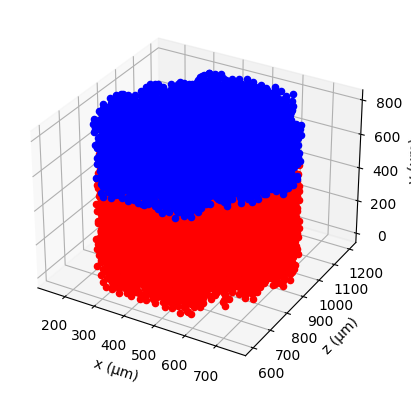

In [13]:
from mpl_toolkits.mplot3d import Axes3D

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(6.4, 4.8))
ax.scatter(df_VPL.x, df_VPL.z, df_VPL.y, c="r", depthshade=False)
ax.scatter(df_Rt.x, df_Rt.z, df_Rt.y, c="b", depthshade=False)

ax.set_xlabel(u'x (μm)')
ax.set_ylabel(u'z (μm)')
ax.set_zlabel(u'y (μm)');

Let's also understand the different m-types in the node population:

In [14]:
node_population.property_values("mtype")

{'Rt_RC', 'VPL_IN', 'VPL_TC'}

Or if one is interested in the m-type, e-type pairs in the population:

In [15]:
node_population.get(properties=['mtype','etype']).drop_duplicates().values

array([['Rt_RC', 'cAD_noscltb'],
       ['Rt_RC', 'cNAD_noscltb'],
       ['VPL_TC', 'dAD_ltb'],
       ['VPL_TC', 'dNAD_ltb'],
       ['VPL_IN', 'bAC_IN']], dtype=object)

## Queries
The `get` method can also be combined with the queries made with `ids`:

In [16]:
Rt_ids = node_population.ids({'region': 'mc2;Rt'})
node_population.get(Rt_ids, properties=['region', 'synapse_class', 'x', 'y', 'z']).head()

,region,synapse_class,x,y,z
node_ids,,,,,
28603,mc2;Rt,INH,175.000000,575.000000,825.000000
28604,mc2;Rt,INH,174.722839,574.845825,862.642334
28605,mc2;Rt,INH,196.455246,556.426147,810.983032
28606,mc2;Rt,INH,171.278717,595.117554,830.635132
28607,mc2;Rt,INH,173.007538,552.684753,837.944153


## Conclusion
Now that we can inspect node properties, the following tutorial will cover retrieving edge properties.